# Goal

We want to have a better understanding of the representation of sea ice in the ECCO model (reanalysis). The goal of this notebook is to plot -
a) ECCO sea ice velocity and ERA-Interim wind velocity
b) ECCO sea ice thickness
c) Relationship between the sea ice thickness and transfer coefficient 
during a similar time frame (1992-2017). In this process, we will be able to understand how wind force influences sea ice in the model. In other words,  we will be able to know how sensitive the sea ice is to the presence of wind.  

In [1]:
%%time
import numpy as np
import xarray as xr
import os
import sys
import glob  
import netCDF4  
import pandas as pd  
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime
from os.path import join,expanduser,exists,split
import cartopy as cartopy
import importlib
import matplotlib.cm as cm
from pathlib import Path
from pprint import pprint
import xgcm as xgcm
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

# identify user's home directory
user_home_dir = expanduser('/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/')
sys.path.append(join(user_home_dir,'ECCO-v4-Python-Tutorial'))
sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco
from ecco_v4_py import get_llc_grid as get_llc_grid
import ecco_access as ea

CPU times: user 9.29 s, sys: 550 ms, total: 9.84 s
Wall time: 9.93 s


## Colormaps and XGCM grid system

Colormaps

In [2]:
# define some useful colormaps where NaNs are black or white
colormaps = {
    'colMap_RdBu_k': (cm.RdBu_r, 'black'),
    'jet_colMap_k': (cm.jet, 'black'),
    'jet_colMap_w': (cm.jet, 'white'),
    'plasma_colMap_k': (cm.plasma, 'black'),
    'plasma_colMap_w': (cm.plasma, 'white'),
    'viridis_colMap_k': (cm.viridis, 'black'),
    'viridis_colMap_w': (cm.viridis, 'white'),
    'inferno_colMap_k': (cm.inferno, 'black'),
    'inferno_colMap_w': (cm.inferno, 'white'),
    'coolwarm_colMap_k': (cm.coolwarm, 'black'),
    'coolwarm_colMap_w': (cm.coolwarm, 'white')
}

# Apply NaN color settings
for name, (colormap, nan_color) in colormaps.items():
    colormap.set_bad(color=nan_color)
    globals()[name] = colormap  # Assign to global variable with the specified name
# Use --> plt.imshow(data, cmap=colMap_RdBu_k) for example

Grid system

In [3]:
# Go to the current working directory
ecco_dir = '/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/data/'
os.chdir(ecco_dir)
# Am I really in the directory?
! pwd
print("\n")

ecco_grid = xr.open_dataset('GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc') 
print("Geometry contains: ",list(ecco_grid.data_vars))
print("\n")

# Make the XGCM object
XGCM_grid = get_llc_grid(ecco_grid)

# look at the XGCM object.
print(XGCM_grid)

/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/data


Geometry contains:  ['CS', 'SN', 'rA', 'dxG', 'dyG', 'Depth', 'rAz', 'dxC', 'dyC', 'rAw', 'rAs', 'drC', 'drF', 'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS', 'maskC', 'maskW', 'maskS']


<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center


## Load sea ice data and model geometry

In [4]:
# Load the NetCDF file using xarray
year = 1992
file_name = ecco_dir + 'ecco_sea_ice_velocity_{y}.nc'.format(y=year)
ecco_ds = xr.open_dataset(file_name) # sea ice data
ecco_ds = xr.merge((ecco_ds , ecco_grid)).compute()
print(list(ecco_ds.data_vars))
ecco_ds

['SIuice', 'SIvice', 'CS', 'SN', 'rA', 'dxG', 'dyG', 'Depth', 'rAz', 'dxC', 'dyC', 'rAw', 'rAs', 'drC', 'drF', 'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS', 'maskC', 'maskW', 'maskS']


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 366, nv: 2,
                nb: 4, k: 50, k_u: 50, k_l: 50, k_p1: 51)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-01T18:00:00 ... 1992-12-31T12:00:00
    ...         ...
  * k_p1       (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    Z          (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu         (k_u) float32 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    Z_bnds     (k, nv) float32 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nv, nb
Data variables: (12/23)
    SIuice     (time, tile, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    SIvice     (time, tile, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    CS         (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN         (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    rA         (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    dxG        (tile, j_g, i) float32 1.558e+04 1.559e+04 ... 2.36e+04 2.314e+04
    ...         ...
    hFacC      (k, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW      (k, tile, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacS      (k, tile, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskC      (k, tile, j, i) bool False False False ... False False False
    maskW      (k, tile, j, i_g) bool False False False ... False False False
    maskS      (k, tile, j_g, i) bool False False False ... False False False
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea-Ice Velocity - Daily Mean llc90 Gr...
    uuid:                         a029ca02-4050-11eb-ac63-0cc47a3f479b

Check if all tiles are alright. Note that, Ioly chose 5 active tiles. Rest ofthtileare not considerd (because they do not contain Arctic ocean, plus, it significantly reduces the size). 

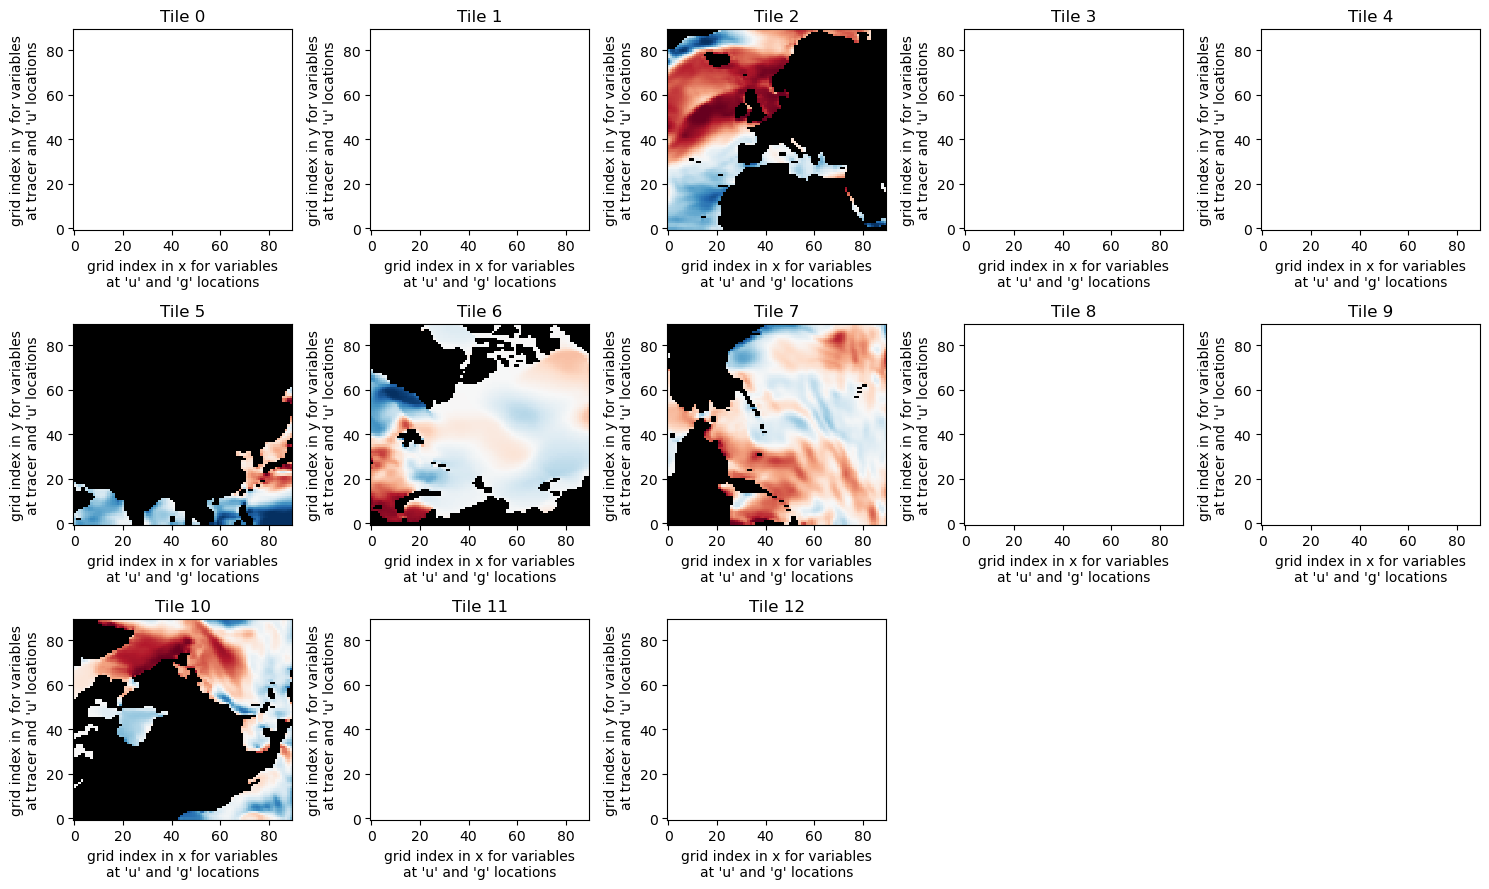

In [5]:
import matplotlib.pyplot as plt

# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Loop to plot each tile in the 3x5 grid, using i = 0 to 12 for the 13 tiles
for i in range(13):  # i goes from 0 to 12, which matches the tile indices in ecco_ds
    row = i // 5     # Calculate row index
    col = i % 5      # Calculate column index
    
    # Access the current subplot
    ax = axes[row, col]
    
    # Plot the data for tile i on the current subplot
    ecco_ds.SIuice.isel(time=0, tile=i).plot(ax=ax, add_colorbar=False)
    ax.set_title(f"Tile {i}")

# Hide the last two empty subplots
for j in range(13, 15):
    fig.delaxes(axes[j // 5, j % 5])


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Convert model to global velocity

Convert $u_x$ and $u_y$ to $\lambda$ and $\phi$ velocity

In [6]:
u_x = ecco_ds.SIuice.copy(deep=True)
v_y = ecco_ds.SIvice.copy(deep=True)

# set land points to nan so that we don't get big gradients between ocean and land
# ... the wet/dry mask for 'u' points is in the 'maskW' field
    # ... the wet/dry mask for 'v' points is in the 'maskS' field
    nan_land_mask_W = ecco_ds.maskW.where(ecco_ds.maskW.isel(k=0) > 0);
    nan_land_mask_S = ecco_ds.maskS.where(ecco_ds.maskS.isel(k=0) > 0);
    
    # mask land points with nan
    u_x = u_x*nan_land_mask_W.isel(k=0)
    v_y = v_y*nan_land_mask_S.isel(k=0)
    
    # confirm that the field is indeed in the native grid format and tracer cell point [dimensions 'tile','i','j']
    # (13 tiles of 90x90)
    print(f'\nuvel dimensions:  {u_x.dims}')
    print(f'uvel shape:       {u_x.shape}')
    print(f'\nvvel dimensions: {v_y.dims}')
    print(f'vvel shape:       {v_y.shape}')

IndentationError: unexpected indent (4283475923.py, line 7)

In [ ]:
## calculate the zonal and meridional components of flow from the u_x and v_y components

# u_x and v_y are located at the model's 'u' and 'v' points, respectively.
# interpolate the vectors to the cell centers at i,j
vec_u_to_ij = XGCM_grid.interp_2d_vector({'X': u_x, 'Y': v_y},boundary='fill')

# vec_u_to_ij is a dictionary holding the interpolated vectors with the 'X' and 'Y' keys.

# rotate the interpolated vectors to the zonal (lambda) and meridional (phi) basis
# Add the zonal components of the 'X' and 'Y' vectors
u_lambda       = vec_u_to_ij['X']*ecco_ds['CS'] - vec_u_to_ij['Y']*ecco_ds['SN']

# Add the meridional components
v_phi          = vec_u_to_ij['X']*ecco_ds['SN'] + vec_u_to_ij['Y']*ecco_ds['CS']


Time to check how different do they look

In [ ]:
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot on the first subplot
u_lambda.isel(time=0, tile=6).plot(ax=axes[0], add_colorbar=True)

# Plot on the second subplot
ecco_ds.SIuice.isel(time=0, tile=6).plot(ax=axes[1], add_colorbar=True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
ecco_ds.SIuice.isel(time=0, tile=6).shape

## Velocity magnitude

c = sqrt(u_lambda$^2$ + v_phi$^2$)

In [ ]:
# Calculate the magnitude of velocity for color mapping
c = np.sqrt(u_lambda**2 + v_phi**2)
c = np.where(~np.isfinite(c), np.nan, c)
# c = np.where(c > 0.5, 0.5, c)

print(f'The shape of speed, c is:       {c.shape}')

Assign u_lambda,v_ph, c i the ecco_ds

In [ ]:
ecco_ds = ecco_ds.assign(u_lambda=u_lambda,
                         v_phi=v_phi, 
                         c=(("time", "tile", "j", "i"), c))
ecco_ds

In [ ]:
print(f'\nu_lambda dimensions: {ecco_ds.u_lambda.dims}')
print(f'u_lambda shape:       {ecco_ds.u_lambda.shape}')
print(f'\nv_phi dimensions: {ecco_ds.v_phi.dims}')
print(f'v_phi shape:       {ecco_ds.v_phi.shape}')
print(f'\nc dimensions: {ecco_ds.c.dims}')
print(f'c shape:       {ecco_ds.c.shape}')

Now, compare between the speed and u_x and u_y

In [ ]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot on the first subplot
ecco_ds.c.isel(time=0, tile=6).plot(ax=axes[0], add_colorbar=True)

# Plot on the first subplot
ecco_ds.u_lambda.isel(time=0, tile=6).plot(ax=axes[1], add_colorbar=True)

# Plot on the second subplot
ecco_ds.v_phi.isel(time=0, tile=6).plot(ax=axes[2], add_colorbar=True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors


# Plot setup
f, ax = plt.subplots(1, 1, figsize=[10, 7.5],
                     subplot_kw={'projection': ccrs.Stereographic(central_latitude=90)})

vector_crs = ccrs.PlateCarree()

# Arctic region extent (approximate)
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

# Normalize color range
norm = mcolors.Normalize(vmin=0, vmax=0.5)

# Quiver plot
h = ax.quiver(ecco_ds.XC.isel(tile=6).values[::2, ::2].ravel(),
              ecco_ds.YC.isel(tile=6).values[::2, ::2].ravel(),
              ecco_ds.u_lambda.isel(time=0, tile=6).values[::2, ::2].ravel(),
              ecco_ds.v_phi.isel(time=0, tile=6).values[::2, ::2].ravel(),
              c[0,6,:,:][::2, ::2].ravel(),  # Use 'c' for color mapping
              scale=8,
              transform=vector_crs,
              width=0.002, 
              cmap='inferno_r', headwidth=12, headlength=6, norm=norm)


# Add land feature and gridlines
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.gridlines(draw_labels=False)

# Colorbar
f.colorbar(h, orientation='vertical', label='Velocity Magnitude [m/s]')

# Title
ax.set_title('Model Velocity Vector [m/s]', fontsize=12)

plt.show()



## Seasonal division

In [ ]:
# Dividing the dataset into four seasons
month_length = ds.time.dt.days_in_month
# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")
ds_weighted